## Trying to make this figure from the Hamilton et al. report

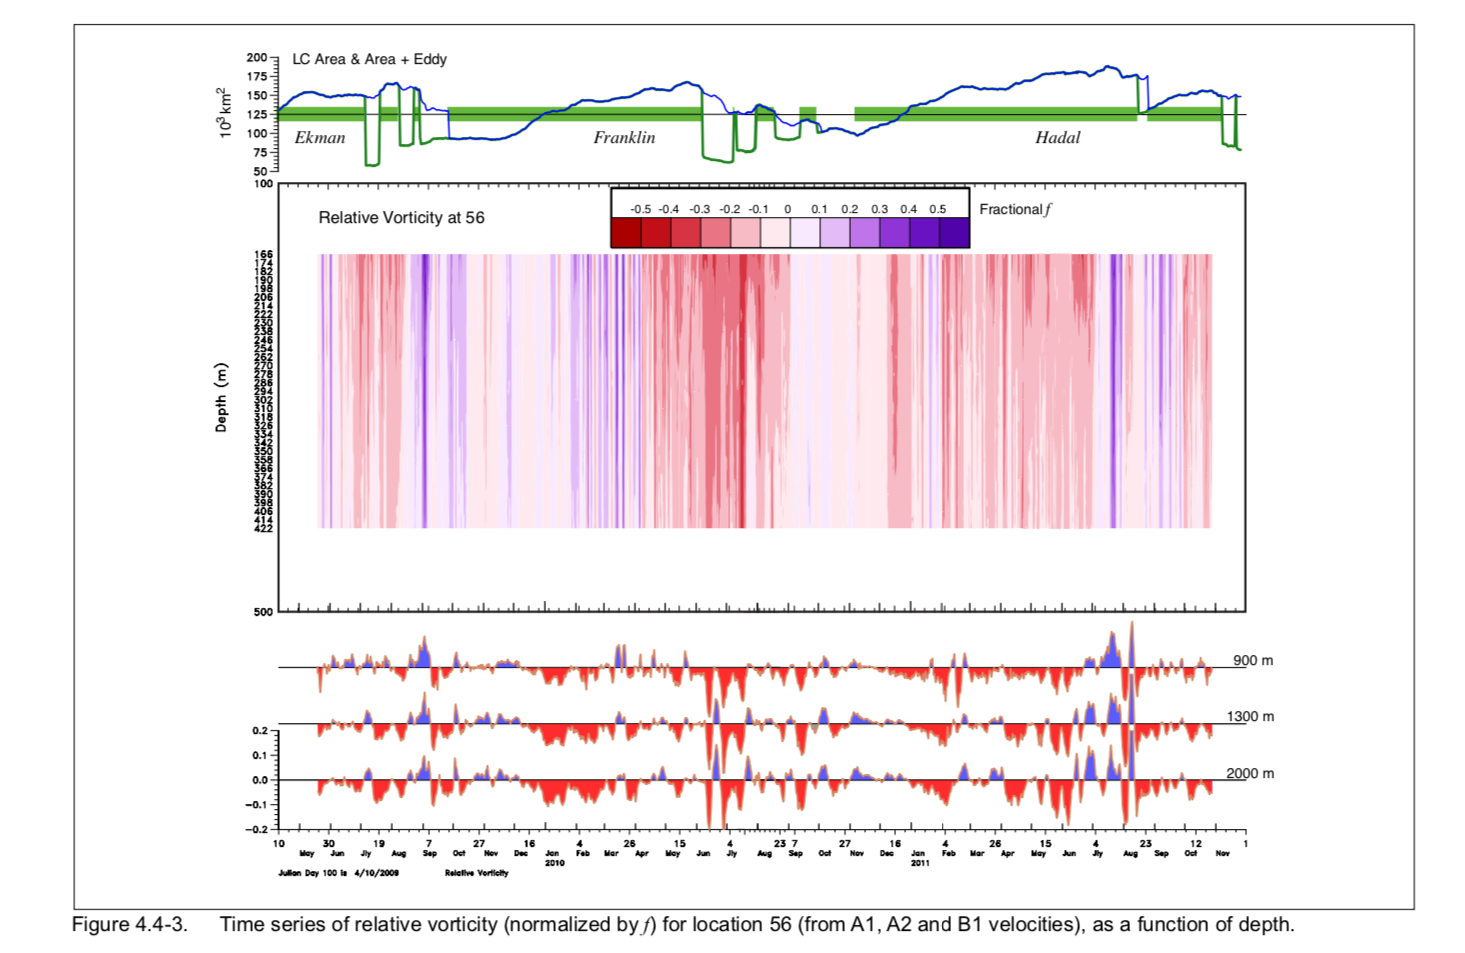

Specifically the middle panel. When they say "at 56" they mean "the depth distribution of ζ is given for location 56 (derived from moorings A1, A2 and B1)", which are located around these coordinates:
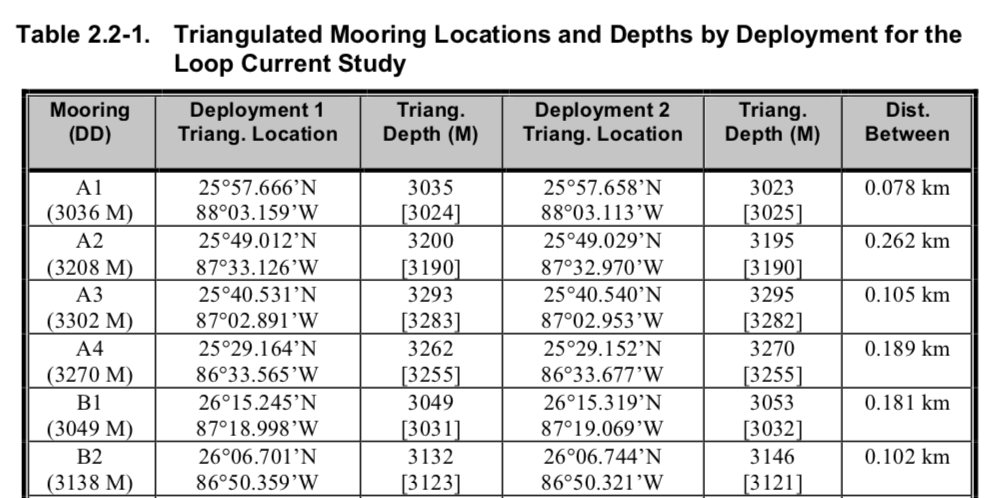

This location is at the northwestward extent of the loop current, with an average latitude of 26.010683 and an average longitude of 87.64046:

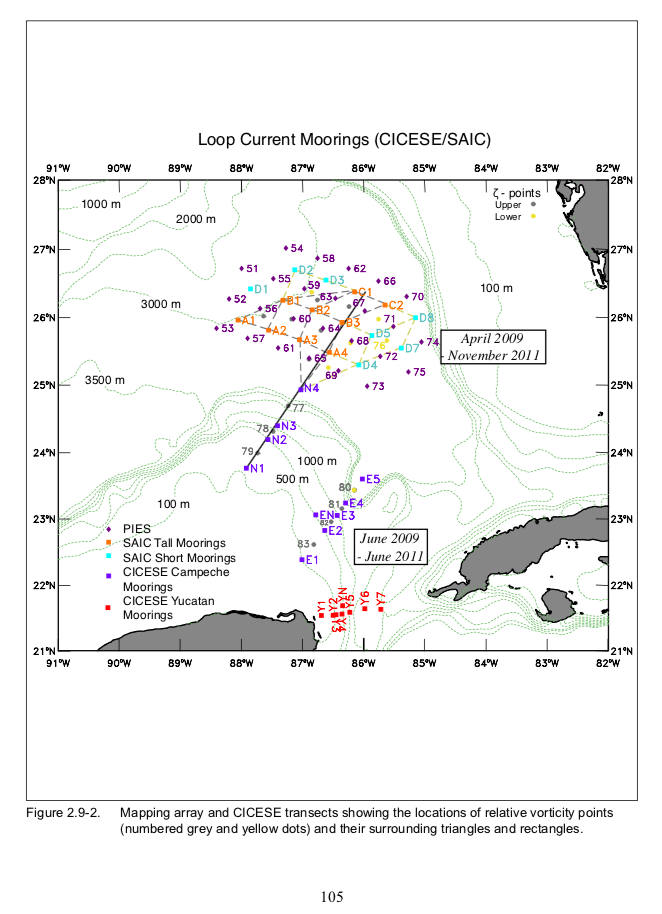


The three stations create a tringle to calulate the velocity gradients:

"Because the observational moorings were laid out in an array, higher dynamical quantities can be calculated by fitting planes through groups of observations. Minimums of three locations (not co-linear) are required to estimate gradients of velocity using:

\begin{equation}
u(x,y,t)=u +x \frac{\partial u}{\partial x}+y \frac{\partial v}{\partial y}(HigherOrderTerms) \; \; \;  (2.9.5)
\end{equation}

with a similar equation for the v-component. When there are more than three locations, least- square fitting is used where the velocity components are weighted by their standard deviations. This is similar to the method given by (Chereskin et al. 2000). "

Relative vorticity is the standard formulation.

We will just average the three locations to get a centroid and call that location 56. 




This script will feature four main tasks:

    1) reading the analysis mean files sequentially

    2) interpolating velocities to depth

    3) calculating centered differences

    4) plotting relative vorticity
   

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from netCDF4 import Dataset

import numpy as np
import Nio,Ngl
import os,sys
import datetime

## 1) reading ensemble mean files sequentially


In [2]:
  path_to_output = "/scratch/rhe/GoM/Data-Assimilation/jan2009b/"
  ndepths = 30
  depths=np.linspace(-166, -422, ndepths)
  #depths=np.linspace(-1, -2000, ndepths)
  latbounds = 25 #26.010683
  lonbounds = -86 #-87.64046   
  #-- open file
  f = Nio.open_file(path_to_output+"instance_0001/roms_posterior_0001_54939.nc","r")
  gridf = Nio.open_file(path_to_output+"instance_0001/useast_ini_0001.nc","r")

  #wks_type = "png"
  #wks = Ngl.open_wks(wks_type,"bc_pkc")
  #Ngl.define_colormap(wks,"default")         # Change color map.

  # Start date and end date
  start_date=datetime.datetime(2009,5,20)
  end_date=datetime.datetime(2009,10,19)


  #############################################################
  days_since=datetime.datetime(1858,11,17)
  start_date_ordinal=datetime.date.toordinal(start_date)
  end_date_ordinal=datetime.date.toordinal(end_date)
  days_since_ordinal=datetime.date.toordinal(days_since)
    
  start_date_index=start_date_ordinal-days_since_ordinal
  end_date_index=end_date_ordinal-days_since_ordinal
    
  # Optional sanity check
  #start_date_string=datetime.date.fromordinal(days_since_ordinal+start_date_index)
  nfiles=int((end_date_index-start_date_index+1)/2)
  filesi=list(range(start_date_index,end_date_index,2))
   
  #ffrac=2*((2*pi)/86400)*sin(26.010683 degrees)
  ffrac=0.00006378287
  h=gridf.variables['h'] # (eta_rho,xi_rho)
  Cs_r = gridf.variables['Cs_r']  # s_rho
  hc_nio   = gridf.variables['hc'] # single value
  hc = hc_nio.get_value()
  vtransform_nio = gridf.variables['Vtransform']
  vtransform = vtransform_nio.get_value()
  Sc_r = gridf.variables['s_rho'] # s_rho
  hinv=1/h[:,:]
 
  pm = gridf.variables['pm'][:,:] # these only change with latitude (non-conformal grid)
  pn = gridf.variables['pn'][:,:]
  dx = 1/pm
  dy = 1/pn
  lats=gridf.variables['lat_rho'][:,0]
  lons=gridf.variables['lon_rho'][0,:]
  # latitude lower and upper index
  latidx = (np.abs(lats - latbounds)).argmin()
  lonidx = (np.abs(lons - lonbounds)).argmin()

 

In [3]:
  ## Keep this in the same cell for easier troubleshooting
  #os.system("rm -rf ../ncs/relvort.nc")     #-- delete file if it exists
  #dataset=Dataset('../ncs/relvort.nc','w',format='NETCDF4_CLASSIC')  #-- create dimensions
  #level = dataset.createDimension('level', ndepths)
  #time = dataset.createDimension('time', 450) # Want to compress what we have to look more like the figure; None ideally
  #nc_relvortplot = dataset.createVariable('relvortplot','f',('level','time'))
  #dataset.close()

  # for i in range(0,nfiles):
  for time in range(45,nfiles):
    print(time,nfiles)
    f = Nio.open_file(path_to_output+"analysis_mean."+str(filesi[time])+".nc","r")
    u=f.variables['u'][0,:,:,:]
    v=f.variables['v'][0,:,:,:]
    t=f.variables['temp']
    z = f.variables['zeta']
    vin = t[0,:,:,:]
    zeta = z[0,:,:]
    njni=zeta.shape
    nj=njni[0]
    ni=njni[1]
    
    
    # Put u and v points onto rho points 
    dims=vin.shape
    
    dimsu  = u.shape
    dimY   = dimsu[1]
    dimX   = dimsu[2]
    ur = np.empty(dims)
    ur[:,:,1:dimX-1] = 0.5*(u[:,:,:dimX-2] + u[:,:,1:dimX-1])
    ur[:,:,0]=ur[:,:,1]
    ur[:,:,dimX]=ur[:,:,dimX-1]
    print(ur.shape)
    print(dimX)
    dimsv  = v.shape
    dimY   = dimsv[1]
    dimX   = dimsv[2]

    vr = np.empty(dims)
    vr[:,1:dimY-1,:] = 0.5*(v[:,:dimY-2,:] + v[:,1:dimY-1,:])
    vr[:,0,:]=vr[:,1,:]
    vr[:,dimY,:]=vr[:,dimY-1,:]
    
    # have all I need for depth calculation
   
    depth=np.empty(dims)
    uinterpolated=np.empty([ndepths,nj,ni])
    vinterpolated=np.empty([ndepths,nj,ni])
    dxinterpolated=np.empty([ndepths,nj,ni])
    relvortplot=np.empty([ndepths,nfiles])
    N=dims[0]

    if vtransform == 2:
      for k in range(0,N):
        cff = 1/(hc + h[:,:])
        cffr = hc*Sc_r[k] + h[:,:]*Cs_r[k]
        depth[k,:,:]=(zeta + ( zeta + h )*cffr*cff)
    if vtransform == 1: 
      for k in range(0,N):
        cffr = hc*(Sc_r[k] - Cs_r[k])
        depth[k,:,:]=cffr+Cs_r[k]*h[:,:] + zeta*(1+(cffr+Cs_r[k]*h)*hinv)
        
    
    for i in range(0,ni-2):
      for j in range(0,nj-2):
        x=depth[:,j,i]
        uplane=ur[:,j,i]
        vplane=vr[:,j,i]
        ui=np.interp(depths,x,uplane)
        uinterpolated[:,j,i]=ui
        vi=np.interp(depths,x,vplane)
        vinterpolated[:,j,i]=vi
    for k in range(0,ndepths):
        dxinterpolated[k,:,:]=dx
    # Now we have two arrays (u and v) that are dimensioned ndepths,nj,ni. We can
    # compute their centered difference using dx and dy from the grid file

    dv = np.gradient(vinterpolated,axis=[2])
    dvdx = dv/dx
    du = np.gradient(uinterpolated,axis=[1])
    dudy = du/dy

    relvort = (dvdx - dudy)/ffrac
    relvortplot[:,time]=relvort[:,latidx,lonidx]
    dataset=Dataset('../ncs/relvort.nc','a',format='NETCDF4_CLASSIC')
    nc_relvortplotb = dataset.variables['relvortplot']
    nc_relvortplotb[:,time] = relvortplot[:,time] # write numpy structured array to netcdf compound var
    dataset.close()

  #nc_relvortplot[:] = relvortplot # write numpy structured array to netcdf compound var

 


45 76
(36, 452, 602)
601
46 76
(36, 452, 602)
601
47 76
(36, 452, 602)
601
48 76
(36, 452, 602)
601
49 76
(36, 452, 602)
601
50 76
(36, 452, 602)
601
51 76
(36, 452, 602)
601
52 76
(36, 452, 602)
601
53 76
(36, 452, 602)
601
54 76
(36, 452, 602)
601
55 76
(36, 452, 602)
601
56 76
(36, 452, 602)
601
57 76
(36, 452, 602)
601
58 76
(36, 452, 602)
601
59 76
(36, 452, 602)
601
60 76
(36, 452, 602)
601
61 76
(36, 452, 602)
601
62 76
(36, 452, 602)
601
63 76
(36, 452, 602)
601
64 76
(36, 452, 602)
601
65 76
(36, 452, 602)
601
66 76
(36, 452, 602)
601
67 76
(36, 452, 602)
601
68 76
(36, 452, 602)
601
69 76
(36, 452, 602)
601
70 76
(36, 452, 602)
601
71 76
(36, 452, 602)
601
72 76
(36, 452, 602)
601
73 76
(36, 452, 602)
601
74 76
(36, 452, 602)
601
75 76
(36, 452, 602)
601
